In [2]:
# #install netcdf4
# conda install -c conda-forge netcdf4

# Import existing code modules
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
from scipy import stats
from scipy import signal

import netCDF4
import os
import glob
import math
import time

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from tqdm import trange
from sklearn.linear_model import LinearRegression

In [3]:
# Set the input and output directories.
input_directory='/Users/mellie/Documents/EXE_ADSS/9  Project  60 credits/2022/'
output_directory = 'Outputs/'

filenames = sorted(glob.glob(os.path.join(input_directory,'*.nc')))
nfiles = len(filenames)
print('Number of files found: ', nfiles)

Number of files found:  161


# Exploratory Data Analysis

## 1. Non spatio-temporal patterns

In [4]:
mask = netCDF4.Dataset(filenames[0])

def landsea_array(nest = 77):
    coast = np.array(mask.variables['field'])[:, :, (nest-1)]
    return coast

def wind_speed(nest = 77):
    # Look at one file
    u = netCDF4.Dataset(filenames[nest])
    v = netCDF4.Dataset(filenames[nest+80])
    
    # Access the field variable
    u_series = np.array(u.variables['field'])
    v_series = np.array(v.variables['field'])[:, :, 0:512]
    speed = np.sqrt(u_series**2 + v_series**2)
    return speed

def wind_direction(nest = 77, x=0, y=0):
    # Access the field variable
    u_series = np.array(u.variables['field'])
    v_series = np.array(v.variables['field'])[:, :, 0:512]
    direction = (270-np.rad2deg(np.arctan2(v_series,u_series)))%360
    return direction

# Calculate the wind direction
# https://github.com/blaylockbk/Ute_WRF/blob/master/functions/wind_calcs.py
# wind["direction"] = (270-np.rad2deg(np.arctan2(wind["v"],wind["u"])))%360

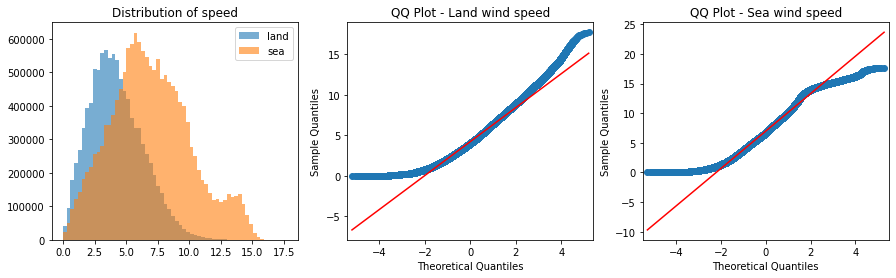

In [5]:
# Nest 77 = the first time series
time_series = wind_speed(nest=77)
mask_77 = landsea_array(nest = 77)

land_speed = time_series*mask_77
sea_speed = time_series*(1-mask_77)

land_speed_add1 = (time_series+1)*mask_77
sea_speed_add1 = (time_series+1)*(1-mask_77)

# Flatten the land_speed array
land_speed_flatten_add1 = land_speed_add1.flatten()
sea_speed_flatten_add1 = sea_speed_add1.flatten()

# Retrieve the original series
land_speed_flatten = land_speed_flatten_add1[np.nonzero(land_speed_flatten_add1)] -1
sea_speed_flatten = sea_speed_flatten_add1[np.nonzero(sea_speed_flatten_add1)] -1

# Plot the histogram
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(land_speed_flatten, bins=60, alpha=0.6, label='land')
axs[0].hist(sea_speed_flatten, bins=60, alpha=0.6, label='sea')
axs[0].legend()
axs[0].set_title('Distribution of speed')

sm.qqplot(land_speed_flatten, line='s', ax=axs[1])
axs[1].set_title('QQ Plot - Land wind speed')

sm.qqplot(sea_speed_flatten, line='s', ax=axs[2])
axs[2].set_title('QQ Plot - Sea wind speed')

plt.show()

## 2. Temporal Patterns

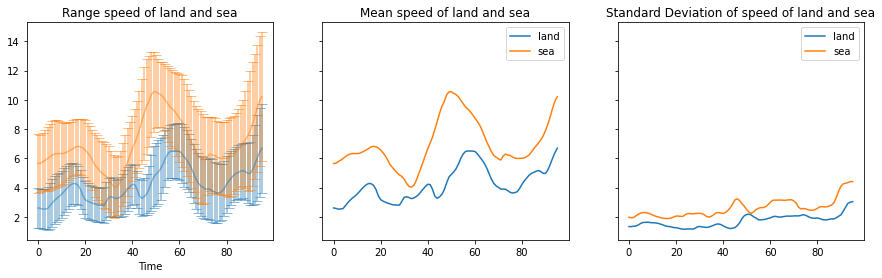

In [6]:
# Construct mean across grid
land_speed_mean_ts = np.sum(land_speed, axis = (1,2))/np.sum(mask_77)
sea_speed_mean_ts = np.sum(sea_speed, axis = (1,2))/np.sum(1-mask_77)

# Construct var across grid
land_speed_var_ts = np.sum((land_speed - land_speed_mean_ts[:, np.newaxis, np.newaxis]*mask_77)**2, axis = (1,2))/np.sum(mask_77)
sea_speed_var_ts = np.sum((sea_speed - sea_speed_mean_ts[:, np.newaxis, np.newaxis]*(1-mask_77))**2, axis = (1,2))/np.sum(1-mask_77)

# Construct standard deviation across grid
land_speed_std_ts = np.sqrt(land_speed_var_ts)
sea_speed_std_ts = np.sqrt(sea_speed_var_ts)

# Plot mean and deviation
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axs[0].errorbar(range(len(land_speed_mean_ts)), land_speed_mean_ts, 
             yerr=land_speed_std_ts,
             fmt='-', markersize=5, capsize=5, alpha = 0.5)
axs[0].errorbar(range(len(sea_speed_mean_ts)), sea_speed_mean_ts, 
             yerr=sea_speed_std_ts,
             fmt='-', markersize=5, capsize=5, alpha = 0.5)
axs[0].set_title('Range speed of land and sea')
axs[0].set_xlabel('Time')

axs[1].plot(land_speed_mean_ts,label='land')
axs[1].plot(sea_speed_mean_ts,label='sea')
axs[1].set_title('Mean speed of land and sea')
axs[1].legend()

axs[2].plot(land_speed_std_ts,label='land')
axs[2].plot(sea_speed_std_ts,label='sea')
axs[2].set_title('Standard Deviation of speed of land and sea')
axs[2].legend()

plt.show()

# Fourier series at some locations

In [7]:
def plot_coastline(nest = 77):
    coast = np.array(mask.variables['field'])[:, :, (nest-1)]
    
    # Create coordinate arrays for x and y
    x = np.arange(coast.shape[0])
    y = np.arange(coast.shape[1])
    
    # Plot the data
    plt.imshow(np.transpose(coast), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='binary', alpha = 0.3)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of nest {nest}')
    plt.show()
    
def fourier_24_12(Y):
    X = pd.DataFrame()
    # Add a constant column for the intercept
    X['intercept'] = np.ones(Y.shape[0])
    X['index'] = np.arange(Y.shape[0])
    X['sinx24h'] = np.sin(2 * np.pi * X['index'] * 1 / 24)
    X['cosx24h'] = np.cos(2 * np.pi * X['index'] * 1 / 24)
    X['sinx12h'] = np.sin(2 * np.pi * X['index'] * 1 / 12)
    X['cosx12h'] = np.cos(2 * np.pi * X['index'] * 1 / 12)

    # Create the linear regression model
    reg = LinearRegression()
    reg.fit(X, Y)

    # Get the coefficients
    intercept = reg.intercept_
    coefficients = reg.coef_
    
    # Get the predicted values
    predicted_values = reg.predict(X)

    # Calculate the residuals
    residuals = Y - predicted_values
    
    result = np.concatenate(([intercept],coefficients[1:], residuals, predicted_values))

    return result

def plot_fourier_result(result_array, nest=77):
    # Create coordinate arrays for x and y
    x = np.arange(result_array.shape[1])
    y = np.arange(result_array.shape[2])

    # Coeff of cycle 24h
    coef_sin_24h = result_array[2, :, :]
    coef_cos_24h = result_array[3, :, :]
    coef_24h = np.sqrt(coef_sin_24h**2 + coef_cos_24h**2)

    # Coeff of cycle 12h
    coef_sin_12h = result_array[4, :, :]
    coef_cos_12h = result_array[5, :, :]
    coef_12h = np.sqrt(coef_sin_12h**2 + coef_cos_12h**2)

    # Residuals mean and std errors
    resid_mean = result_array[6:102, :, :]
    resid_mean_arr = np.mean(resid_mean, axis=0)
    resid_std_arr = np.std(resid_mean, axis=0)

    # Plot the location
    plot_coastline(nest = nest)

    # Plot model results 
    plt.imshow(np.transpose(result_array[1, :, :]), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient linear trend')
    plt.show()

    plt.imshow(np.transpose(coef_24h), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient cycle 24h')
    plt.show()

    plt.imshow(np.transpose(coef_12h), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient cycle 12h')
    plt.show()

    plt.imshow(np.transpose(resid_mean_arr), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of mean of residuals')
    plt.show()

    plt.imshow(np.transpose(resid_std_arr), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of standard error of residuals')
    plt.show()

    # Show the plot
    

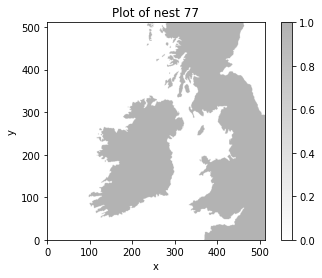

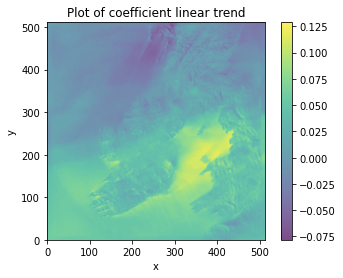

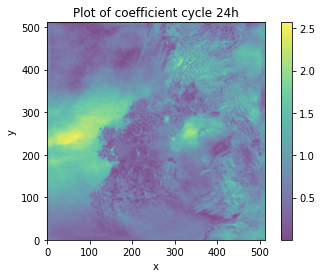

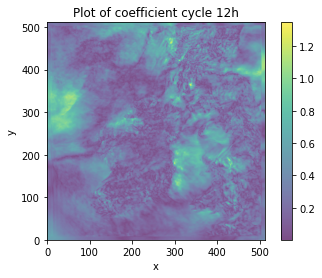

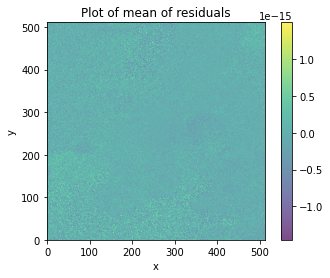

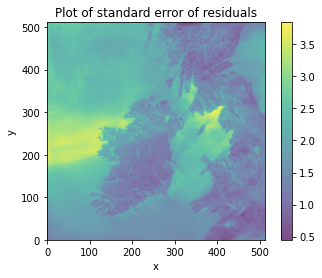

In [29]:
# Location 1: Ireland - GB
time_series = wind_speed(nest = 77)
result_array = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series)
plot_fourier_result(result_array, nest=77)

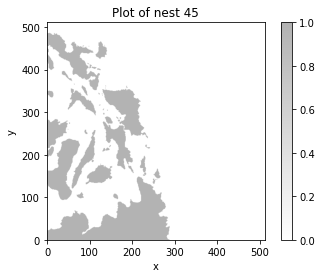

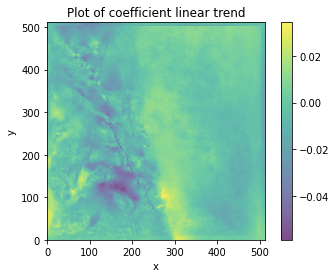

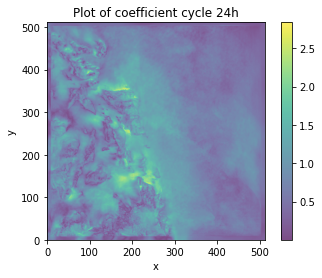

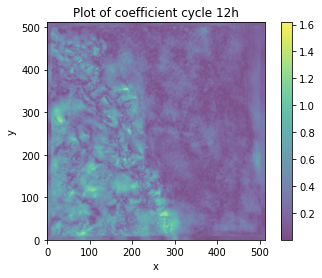

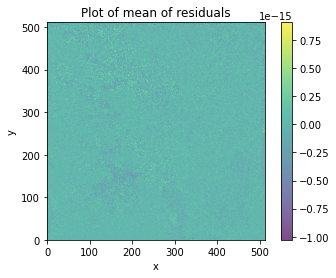

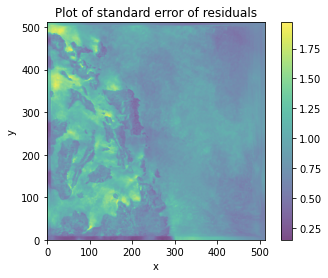

In [9]:
# Location 2: Phillipines
time_series2 = wind_speed(nest=45)
result_array2 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series2)
plot_fourier_result(result_array2, nest=45)

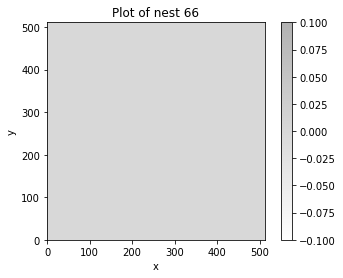

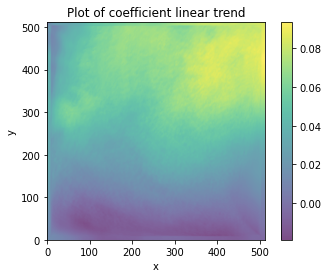

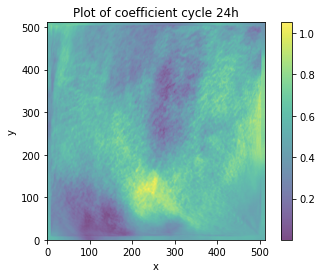

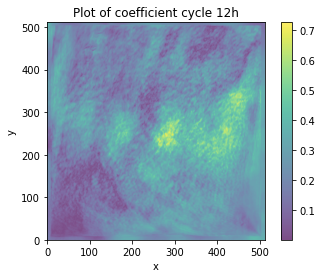

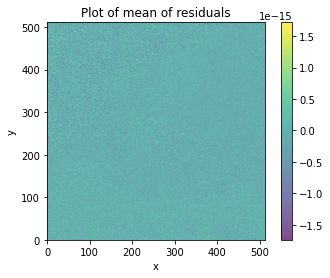

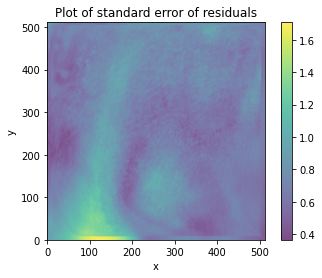

In [10]:
# Location 3: Atlantic Ocean to the east of Gulf stream
time_series3 = wind_speed(nest=66)
result_array3 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series3)
plot_fourier_result(result_array3, nest=66)

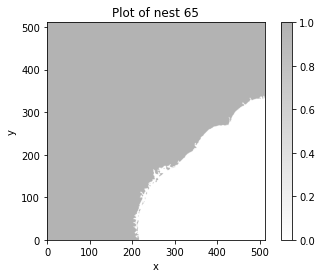

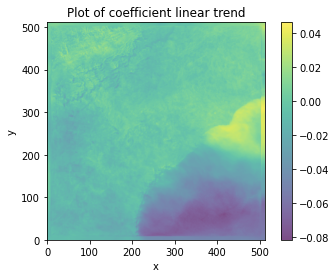

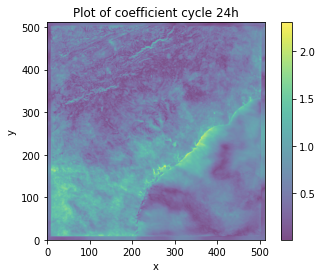

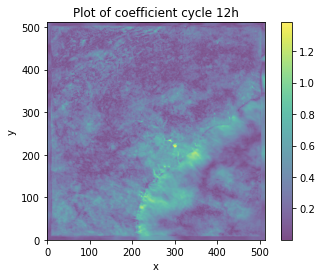

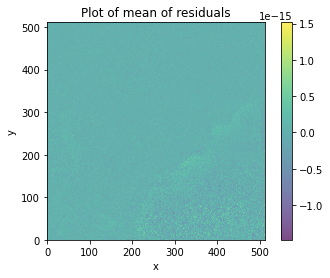

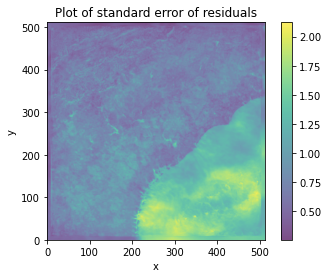

In [11]:
# Location 4: ~ Atlanta coastal line
time_series4 = wind_speed(nest=65)
result_array4 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series4)
plot_fourier_result(result_array4, nest=65)

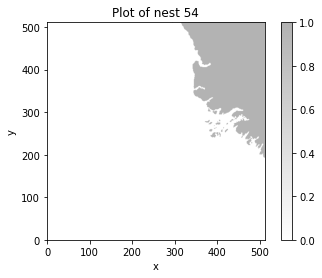

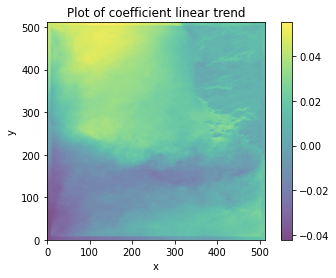

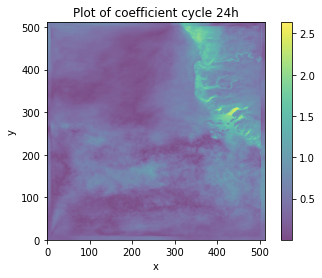

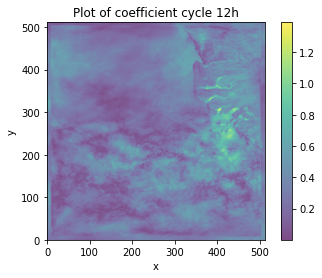

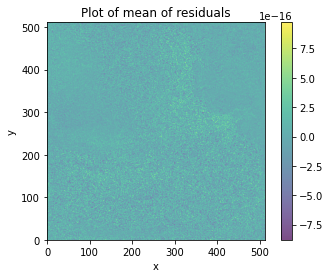

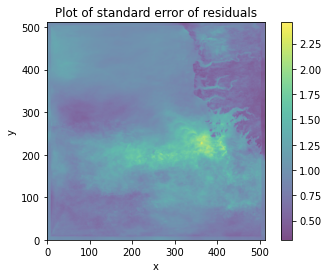

In [12]:
# Location 5: Sahel
time_series5 = wind_speed(nest=54)
result_array5 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series5)
plot_fourier_result(result_array5, nest=54)

# Residuals Analysis

In [13]:
# Define function to AR(1) the residuals
resid = result_array[6:102, :, :]

def AR1_residuals_params(residual):
    model = sm.tsa.arima.ARIMA(residual, order=(1, 0, 0))
    try:
        results_AR = model.fit(return_params=True, low_memory=True)
        return results_AR[1]
    except ValueError:
        return 0

import warnings
# Ignore the ConvergenceWarning temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    residuals_model = np.apply_along_axis(AR1_residuals_params, axis=0, arr=resid)

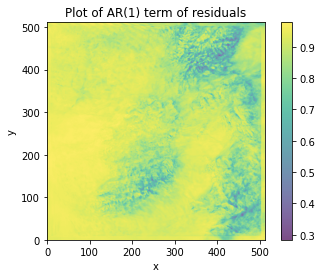

In [14]:
x = np.arange(residuals_model.shape[0])
y = np.arange(residuals_model.shape[1])
plt.imshow(np.transpose(residuals_model), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Plot of AR(1) term of residuals')
plt.show()

In [15]:
# np.where(residuals_model == residuals_model.min())

# residuals_model.min()
residuals_model[353,417]

0.28366747407702997

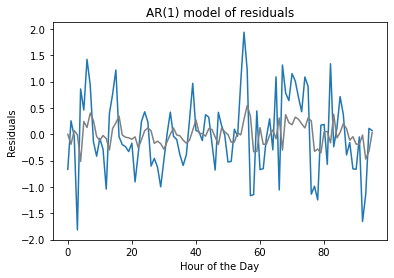

In [16]:
resid_check = result_array[6:102, 353, 417]

model_check = sm.tsa.arima.ARIMA(resid_check, order=(1, 0, 0), trend='c')  
results_AR_check = model_check.fit()

plt.plot(resid_check)
plt.plot(results_AR_check.fittedvalues, color='gray')
# plt.plot(resid_check - results_AR_check.fittedvalues, color='red')
plt.title('AR(1) model of residuals')
plt.xlabel('Hour of the Day')
plt.ylabel('Residuals')
plt.show()

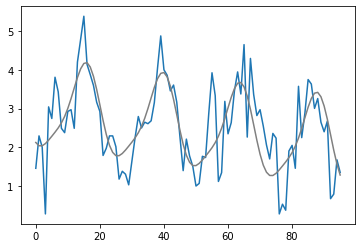

In [83]:
pred_array = result_array[102:, 353, 417]

plt.plot(time_series[:, 353, 417])
plt.plot(pred_array, color='gray')

In [84]:
result_array[:, 353, 417]

array([ 3.06605012, -0.01066067, -0.78602777, -0.76797365,  0.1610097 ,
       -0.1736037 , -0.66673485,  0.25439036, -0.03536441, -1.81672436,
        0.85900795,  0.45872619,  1.4202757 ,  0.93159512, -0.14078765,
       -0.41804087, -0.07909899, -0.28508333, -1.04188476,  0.39906829,
        0.76340625,  1.21917004, -0.04630272, -0.19666391, -0.23474447,
       -0.3290688 , -0.17075836, -0.90420482, -0.3567807 ,  0.24305691,
        0.42607824,  0.23111601, -0.60416312, -0.45970669, -0.62404649,
       -0.99895361, -0.4896876 ,  0.00853811,  0.41954615, -0.04047207,
       -0.10071514, -0.39036652, -0.59277203, -0.39215207,  0.27685408,
        0.96646358,  0.07138219,  0.04303791, -0.12060412,  0.36975758,
        0.32367011, -0.17423   , -0.67980561,  0.41569397,  0.16382324,
       -0.01821158, -0.52755462, -0.51652021,  0.09453824, -0.03731842,
        1.0078992 ,  1.93600434,  1.21573339, -1.16658196, -1.14727047,
        0.44230019, -0.67224307, -0.65427558, -0.05849445,  0.29

## Spatial Average

In [18]:
def spatial_average(time_series, block_size=16):
    block_size = 16
    num_blocks = time_series.shape[1] // block_size
    reshape = time_series.reshape(
        (time_series.shape[0], num_blocks, block_size, num_blocks, block_size)
    )
    mean_data = np.mean(reshape, axis=(2, 4))
    return mean_data

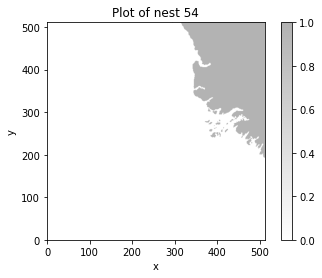

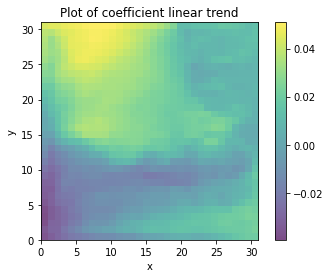

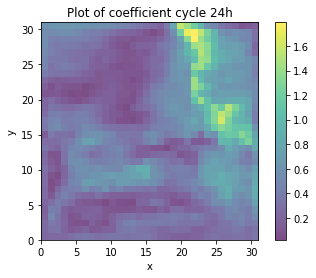

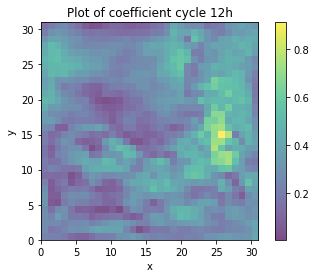

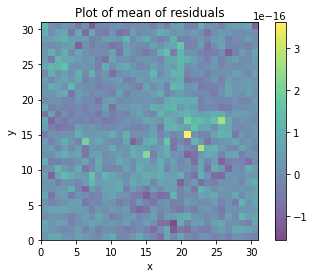

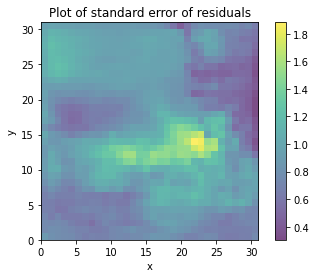

In [26]:
# average coefficients
coeff5_avg = spatial_average(result_array5, block_size=16)
plot_fourier_result(coeff5_avg, nest=54)

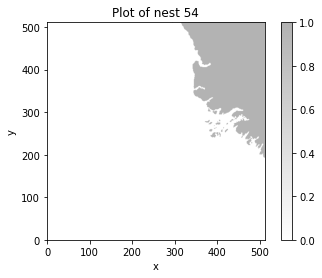

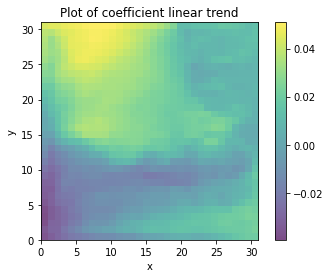

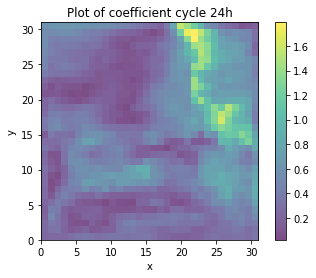

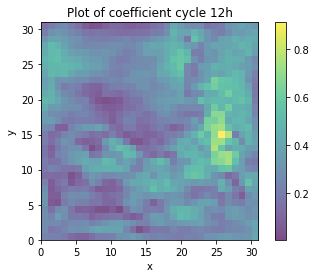

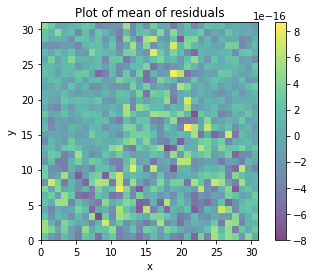

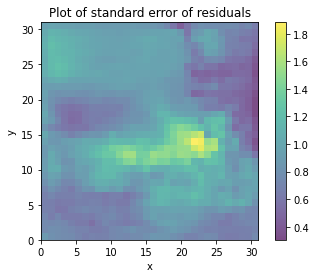

In [28]:
# average wind speed data then plot coeffs
time_series5_avg = spatial_average(time_series5, block_size=16)
result_array5_avg = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series5_avg)
plot_fourier_result(result_array5_avg, nest=54)

In [32]:
diff_5 = result_array5_avg[:6] - coeff5_avg[:6]

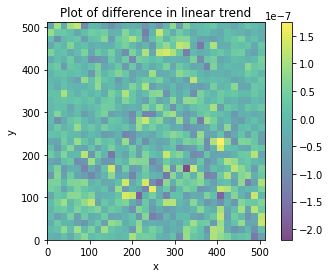

In [43]:
# The difference is nearly 0
    plt.imshow(np.transpose(diff_5[0, :, :]), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of difference in linear trend')
    plt.show()

-0.0

## Residuals at location 1 (0,0) 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


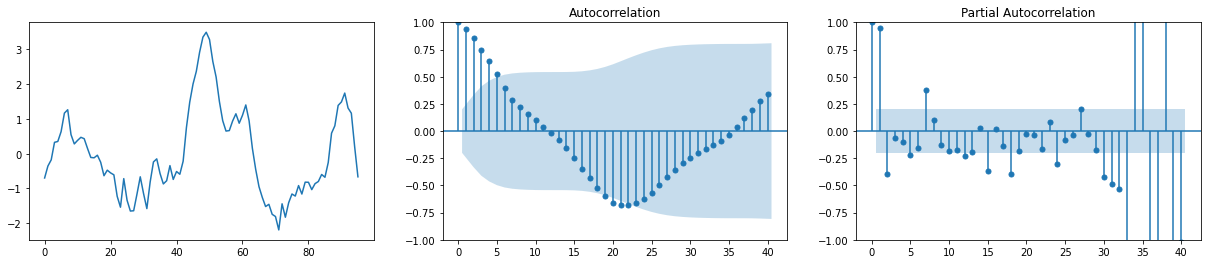

In [84]:
# Check acf residual at one point
fig, axs = plt.subplots(1, 3, figsize=(21, 4))
axs[0].plot(resid[:,0,0])
plot_acf(resid[:,0,0], lags=40, ax = axs[1])
plot_pacf(resid[:,0,0], lags=40, ax = axs[2])
plt.show()

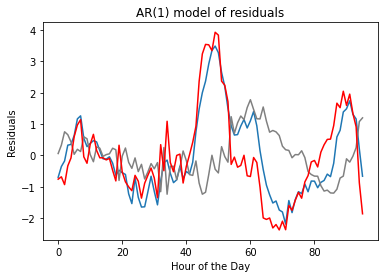

In [219]:
model = sm.tsa.arima.ARIMA(resid[:, 0, 0], order=(1, 0, 0), trend='c')  
results_AR = model.fit()

plt.plot(resid[:, 0, 0])
plt.plot(results_AR.fittedvalues, color='gray')
plt.plot(resid[:, 0, 0] - results_AR.fittedvalues, color='red')
plt.title('AR(1) model of residuals')
plt.xlabel('Hour of the Day')
plt.ylabel('Residuals')
plt.show()

In [261]:
results_AR.params[1]

0.9390126250021742

## Residuals at location 2 (400,100) 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


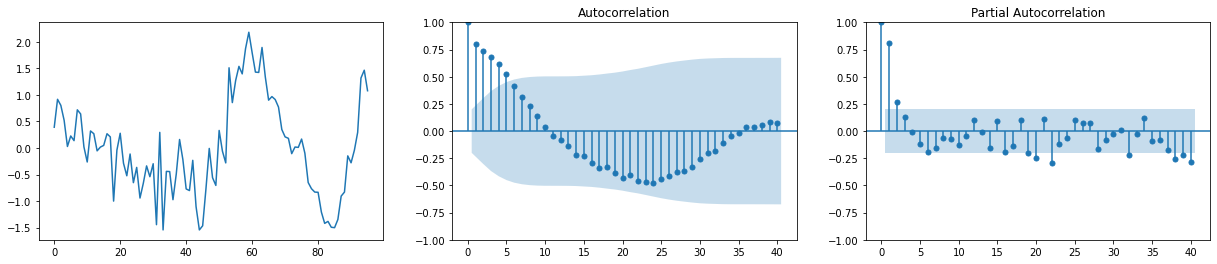

In [214]:
# Check acf residual at one point
fig, axs = plt.subplots(1, 3, figsize=(21, 4))
axs[0].plot(resid[:,400,100])
plot_acf(resid[:,400,100], lags=40, ax = axs[1])
plot_pacf(resid[:,400,100], lags=40, ax = axs[2])
plt.show()

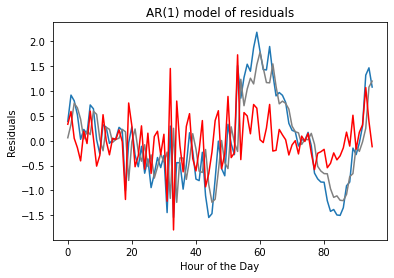

In [215]:
model = sm.tsa.arima.ARIMA(resid[:,400,100], order=(1, 0, 0), trend='c')  
results_AR = model.fit()

plt.plot(resid[:, 400,100])
plt.plot(results_AR.fittedvalues, color='gray')
plt.plot(resid[:, 400,100] - results_AR.fittedvalues, color='red')
plt.title('AR(1) model of residuals')
plt.xlabel('Hour of the Day')
plt.ylabel('Residuals')
plt.show()

In [216]:
results_AR.arparams

array([0.80968422])

## Diurnal Analysis

In [ ]:
#Diurnal analysis of residuals
diurnal_resid = resid.values.reshape(24, 4)

# Calculate the mean wind for each hour
mean_resid = np.mean(diurnal_resid, axis=1)

# Calculate the standard deviation of wind for each hour
std_resid = np.std(diurnal_resid, axis=1)

# Plot the diurnal wind data
plt.errorbar(hours, mean_resid, yerr=std_resid, fmt='o-', capsize=4)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Residuals from frequency states model')
plt.title('Diurnal Plot of Hourly Residual')
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
adfuller_test(resid.dropna())

In [ ]:
hours = np.arange(24)
diurnal_resid2 = resid2.values.reshape(24, 4)

# Calculate the mean wind for each hour
mean_resid2 = np.mean(diurnal_resid2, axis=1)

# Calculate the standard deviation of wind for each hour
std_resid2 = np.std(diurnal_resid2, axis=1)

# Plot the diurnal wind data
plt.errorbar(hours, mean_resid2, yerr=std_resid2, fmt='o-', capsize=4)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Wind Speed')
plt.title('Diurnal Plot of Hourly Residual')
plt.grid(True)

# Display the plot
plt.show()

# Spatial average

average procedure
https://www.ndbc.noaa.gov/faq/wndav.shtml 
- scalar average
- vector average

In [ ]:
# Reshape the dataset to (32, 32, 256)

reshaped_data = field_u[0].reshape(32, 16, 32, 16).mean(axis=(1, 3))

# Calculate the vector average along the first two dimensions
vector_average = reshaped_data.mean(axis=(0, 1))


In [ ]:
def spatial_average(ndarray, to_size):
    from_size=ndarray.shape
    reshape = ndarray.reshape(to_size, int(from_size[0]/to_size), to_size, int(from_size[1]/to_size)).mean(axis=(1, 3))
    return reshape

In [ ]:
test = spatial_average(field_u[0], 32)

In [ ]:
# Get the coordinates for the scatter plot
x, y = np.meshgrid(np.arange(32), np.arange(32))

# Flatten the data and coordinates arrays
test_flat = test.flatten()
x_flat = x.flatten()
y_flat = y.flatten()

# Create a scatter plot
plt.scatter(x_flat, y_flat, c=np.transpose(test_flat), cmap='viridis')
plt.colorbar(label='u average')
plt.show()

In [ ]:
plt.scatter(nest77["x"], nest77["y"], c=nest77["u"], cmap='viridis')
plt.colorbar(label='u')
plt.show()

# Wavelet part

In [ ]:
# Cell wavelet

import pywt
# Define the wavelet and decomposition level
wavelet = 'db4'
level = 2

# Perform wavelet decomposition
coeffs = pywt.wavedec(resid[:,0,0], wavelet, level=level)

# Extract the approximation and detail coefficients
approximation = coeffs[0]
details = coeffs[1:]

# Print the approximation and detail coefficients
print("Approximation coefficients:", approximation)
for i, detail in enumerate(details):
    print(f"Detail coefficients (level {i+1}):", detail)

peakind = signal.find_peaks_cwt(resid[:,400,100], np.arange(1,24))
peakind, resid[:,400,100][peakind]
peakind[np.argmax(resid[:,400,100][peakind])]

def find_peak_residual(residual):
    peakind = signal.find_peaks_cwt(residual, np.arange(1,24))
    peakind = np.array(peakind, dtype=int)
    peak_time = peakind[np.argmax(residual[peakind])]
    peak_valu = max(residual[peakind])
    return peak_time, peak_valu

resid_peak_array = np.apply_along_axis(find_peak_residual, axis=0, arr=resid)


In [ ]:
resid = result_array[6:, :, :]
coast = np.array(mask.variables['field'])[:, :, (77-1)]

resid_std_arr = np.std(resid, axis=0)

C = resid_std_arr*coast
std_land = np.sum(C)/np.sum(coast)
std_land

D = resid_std_arr*(1-coast)
std_sea = np.sum(D)/(np.sum(1-coast))
std_sea

## Wind direction

In [5]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
matplotlib.use('TkAgg')

data = np.random.rand(96,100,100)

fig, ax = plt.subplots()

ax.set_xlim((0, 512))
ax.set_ylim((0, 512))

im = ax.imshow(data[0,:,:])

def init():
    im.set_data(data[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = data[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=24, interval=10, blit=True)

HTML(anim.to_html5_video())

TclError: couldn't open "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/images/matplotlib_128.ppm": no such file or directory

In [2]:
import matplotlib
print(matplotlib.get_backend())

TkAgg


In [3]:
pip install --upgrade matplotlib

     |████████████████████████████████| 7.4 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 4.8 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
# !pip uninstall matplotlib -y

!pip install matplotlib

  Using cached matplotlib-3.7.2-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
